In [1]:
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

In [2]:
import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)


In [3]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df=pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    feature_dup_df=feature_dup_df.reset_index()
    new_feature_name_df=pd.merge(old_feature_name_df.reset_index(),feature_dup_df,how='outer')
    new_feature_name_df['column_name']=new_feature_name_df[['column_name','dup_cnt']].apply(lambda x:x[0]+'_'+str(x[1])
                                                                                         if x[1]>0 else x[0], axis=1)
    new_feature_name_df=new_feature_name_df.drop(['index'],axis=1)
    return new_feature_name_df

In [4]:
def get_human_dataset():
    feature_name_df=pd.read_csv('./human_activity/features.txt',sep='\s+',header=None,names=['column_index','column_name'])
    new_feature_name_df=get_new_feature_name_df(feature_name_df)
    #new_feature_name_df.to_csv('a.csv') #csv로저장
    feature_name=new_feature_name_df.iloc[:,1].values.tolist()
    x_train=pd.read_csv('./human_activity/train/X_train.txt',sep='\s+',names=feature_name)
    x_test=pd.read_csv('./human_activity/test/X_test.txt',sep='\s+',names=feature_name)
    y_train=pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test=pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    return x_train,x_test,y_train,y_test
x_train,x_test,y_train,y_test=get_human_dataset()

In [5]:
print(x_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [6]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [7]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
dt_clf=DecisionTreeClassifier(random_state=156)
dt_clf.fit(x_train,y_train)
pred=dt_clf.predict(x_test)
accuracy = accuracy_score(y_test,pred)
print('{0:.4f}'.format(accuracy))
print(dt_clf.get_params())

0.8548
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [8]:
from sklearn.model_selection import GridSearchCV

params={'max_depth':[6,8,10,12,16,20,24]}
grid_cv=GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(x_train,y_train)
print('정확도:{0:.4f}'.format(grid_cv.best_score_))
print('파라미터',grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
정확도:0.8513
파라미터 {'max_depth': 16}


In [9]:
cv_results_df=pd.DataFrame(grid_cv.cv_results_)
cv_results_df[['param_max_depth','mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [10]:
max_depths=[6,8,10,12,16,20,24]
for depth in max_depths:
    dt_clf=DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(x_train,y_train)
    pred=dt_clf.predict(x_test)
    accuracy=accuracy_score(y_test,pred)
    print(accuracy)

0.8557855446216491
0.8707159823549372
0.8673227010519172
0.8646080760095012
0.8574821852731591
0.8547675602307431
0.8547675602307431


In [11]:
params={'max_depth':[8,12,16,20],'min_samples_split':[16,24]}
grid_cv=GridSearchCV(dt_clf,param_grid=params,scoring='accuracy',cv=5,verbose=1)
grid_cv.fit(x_train,y_train)
print('최고평균정확도{0:.4f}'.format(grid_cv.best_score_))
print('최적하이퍼파라미터',grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
최고평균정확도0.8549
최적하이퍼파라미터 {'max_depth': 8, 'min_samples_split': 16}


In [12]:
best_dt_clf=grid_cv.best_estimator_
pred1=best_dt_clf.predict(x_test)
accuracy=accuracy_score(y_test,pred1)
print(accuracy)

0.8717339667458432


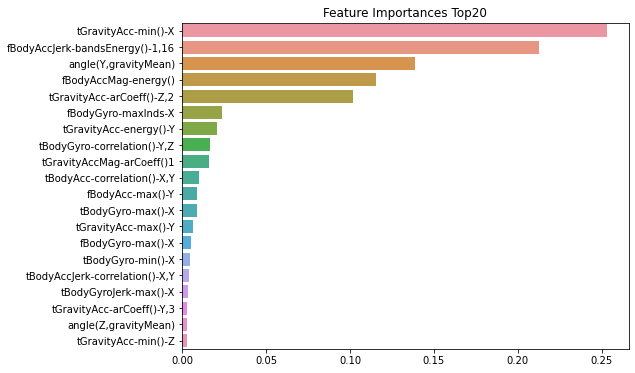

In [13]:
import seaborn as sns
ftr_importances_values=best_dt_clf.feature_importances_
ftr_importances=pd.Series(ftr_importances_values, index=x_train.columns)
ftr_top20=ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature Importances Top20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()